# **Описание проекта**
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.
# **Инструкция для проекта**
Решить задачу можно как с помощью BERT, так и без этой нейронки. Если хотите попробовать BERT —
 - Выполните проект локально. В тренажере тетрадь Jupyter ограничена 4 ГБ оперативной памяти — для проекта с BERT этого может не хватить.
 - Упомяните BERT в заголовке проекта в первой ячейке


Выполнить проект без BERT можно локально или в нашем тренажёре.

В любом случае алгоритм решения выглядит так:

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

# **Описание данных**
Данные находятся в файле /datasets/toxic_comments.csv. Скачать датасет.
Столбец text в нём содержит текст комментария, а toxic — целевой признак.

# **1. Загрузите и подготовьте данные**

## **1.1 Загрузка данных**

In [1]:
pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
import re
import torch

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = (stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import spacy

from catboost import CatBoostClassifier, Pool, metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
url = 'https://drive.google.com/file/d/1tJymBdgfGdfDhKGJLKwx8_ppjnIm5aUs/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
data = df.copy()
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.loc[df['Unnamed: 0']!=df.index].tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


In [5]:
df.loc[df.index[-1], 'Unnamed: 0'] - df.index[-1]

159

**По столбцу `Unnamed: 0` можно сделать вывод,что изначально из датафрейма было удалено 159 строк. Возможно там были пустые значения, либо комментарии были слишком токсичные. В любом случае этот столбец не несет никакой информационной составляющей и его можно удалить из датафрейма для экономии памяти.**

In [6]:
df = df.drop('Unnamed: 0', axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
df['toxic'].value_counts(normalize=True)

,proportion
toxic,
0,0.898388
1,0.101612


**Целевой признак имеет сильный дисбаланс классов в отношении 1:9. Пропущенных значений нет.**

## **1.2 Подготовка признаков**

Лемматизируем твиты с помощью библиотеки `spacy`

In [9]:
disabled_pipes = ['parser', 'ner']
nlp = spacy.load("en_core_web_sm", disable=disabled_pipes)
list_lemmatized = []
for i in notebook.tqdm(df['text']):
    word = nlp(i)
    list_lemmatized.append(" ".join([token.lemma_ for token in word]))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
df.loc[0,'text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [11]:
list_lemmatized[0]

'Explanation \n why the edit make under my username Hardcore Metallica Fan be revert ? they be not vandalism , just closure on some gas after I vote at New York Dolls FAC . and please do not remove the template from the talk page since I be retire now.89.205.38.27'

Напишем функцию, чтобы оставить только символы латинского алфавита в нижнем и верхнем регистре, а так же символ `.`(точки)

In [12]:
def clear_text(text):
    s = re.sub(r"[^a-zA-z.' ]", ' ', text)
    s = s.split()
    return ' '.join(s).lower()

In [13]:
list_lemmatized_cleared = []
for i in notebook.tqdm(list_lemmatized):
    list_lemmatized_cleared.append(clear_text(i))

  0%|          | 0/159292 [00:00<?, ?it/s]

Создадим колонку `list_lemmatized_cleared` с очищенным лемматизированным текстом.

In [14]:
df['list_lemmatized_cleared'] = list_lemmatized_cleared
features = df['list_lemmatized_cleared']
target = df['toxic']

In [15]:
list_lemmatized_cleared[1]

"d'aww he match this background colour i be seemingly stick with . thank . talk january utc"

In [16]:
df.head()

,text,toxic,list_lemmatized_cleared
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i be really not try to edit war . it b...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero . any chance you remember w...


Разделим датасет на обучающую, вадидационную и тестовую выборки в пропорциях 60:20:20

In [17]:
train, test = train_test_split(df, test_size = 0.4, random_state = 1234)
test, valid = train_test_split(test, test_size = 0.5, random_state = 1234)
print('Размер обучающей выборки - ', train.shape)
print('Размер валидационной выборки - ', valid.shape)
print('Размер тестовой выборки - ', test.shape)
print('Отношение кол-ва строк обучающей выборки к кол-ву строк всего датасета - ', round(train.shape[0]/df.shape[0],2))

Размер обучающей выборки -  (95575, 3)
Размер валидационной выборки -  (31859, 3)
Размер тестовой выборки -  (31858, 3)
Отношение кол-ва строк обучающей выборки к кол-ву строк всего датасета -  0.6


In [18]:
corpus_train = train['list_lemmatized_cleared'].values
corpus_test = test['list_lemmatized_cleared'].values
corpus_valid = valid['list_lemmatized_cleared'].values


Создадим векторные признаки с помощью `TfidfVectorizer`.

In [19]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [20]:
features_train = count_tf_idf.fit_transform(corpus_train)
features_test = count_tf_idf.transform(corpus_test)
features_valid = count_tf_idf.transform(corpus_valid)

target_train = train['toxic']
target_test = test['toxic']
target_valid = valid['toxic']

# **2. Обучите разные модели**

## **2.1 Логистическая регрессия**

In [21]:
%%time
model_log_reg = LogisticRegression(class_weight = 'balanced', solver = 'liblinear')
model_log_reg.fit(features_train, target_train)

CPU times: user 3.7 s, sys: 52.8 ms, total: 3.75 s
Wall time: 2 s


LogisticRegression(class_weight='balanced', solver='liblinear')

In [22]:
predict = (model_log_reg.predict(features_valid))
f1_log_res_valid = f1_score(predict, target_valid)
f1_log_res_valid

0.7538270583367811

In [23]:
f1_lst = []
f1_max = 0
c_max = None
for i in notebook.tqdm(np.arange(1.0, 15.5, 0.5)):
  model_log_reg = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', C=i)
  model_log_reg.fit(features_train, target_train)
  preds = model_log_reg.predict(features_valid)
  f1= f1_score(preds, target_valid)
  f1_lst.append(f1)
  if f1>f1_max:
    f1_max = f1
    c_max = i
print(f'Максимальное значение f1-меры = {f1_max:.4f} при значении гиперпараметра с =  {c_max}')


  0%|          | 0/29 [00:00<?, ?it/s]

Максимальное значение f1-меры = 0.7693 при значении гиперпараметра с =  8.0


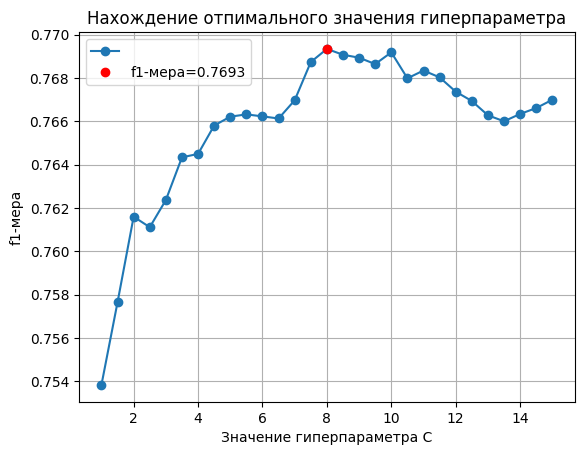

In [24]:
ax = pd.Series(f1_lst, index = np.arange(1.0, 15.5, 0.5)).plot(style='o-', grid=True)
pd.Series(f1_max, index = [c_max]).plot(color='r', style='o', ax=ax, grid=True, legend=True)
plt.title('Нахождение отпимального значения гиперпараметра')
plt.xlabel('Значение гиперпараметра С')
plt.ylabel('f1-мера')
plt.legend([None, 'f1-мера=0.7693'])
plt.show()


In [25]:
model_log_reg = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', C=8)
model_log_reg.fit(features_train, target_train)
preds = model_log_reg.predict(features_valid)
f1= f1_score(preds, target_valid)
f1

0.7693430656934307

In [26]:
f1_lst = []
f1_max = 0
t = None
for threshold in notebook.tqdm(np.arange(0.6, 0.8, 0.005)):
  model_log_reg = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', C=8)
  model_log_reg.fit(features_train, target_train)
  proba = model_log_reg.predict_proba(features_valid)
  preds = (proba[:,1]>=threshold).astype(int)
  f1 = f1_score(target_valid, preds)
  f1_lst.append(f1)
  if f1>f1_max:
    f1_max = f1
    t = threshold
print(f'Максимальное значение f1-меры = {f1_max:.4f} при пороге равном {t}')
f1_max_reg = f1_max

  0%|          | 0/41 [00:00<?, ?it/s]

Максимальное значение f1-меры = 0.7847 при пороге равном 0.675


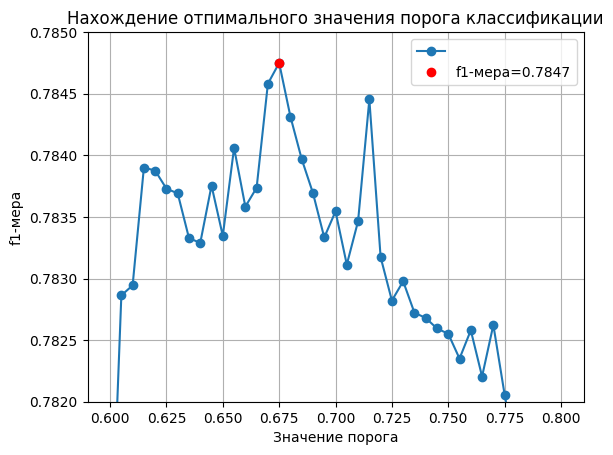

In [27]:
ax = pd.Series(f1_lst, index = np.arange(0.6, 0.8, 0.005)).plot(grid=True, style='o-')
pd.Series(f1_max, index = [t]).plot(color='r', style='o', ax=ax, grid=True, legend=True)
plt.title('Нахождение отпимального значения порога классификации')
plt.xlabel('Значение порога')
plt.ylabel('f1-мера')
plt.ylim(0.782, 0.7850)
plt.legend([None,'f1-мера=0.7847'])
plt.show()

## **2.2 Решающее дерево**

In [28]:
for depth in notebook.tqdm(range(2,20)):
  model_dtс = DecisionTreeClassifier(class_weight = 'balanced', max_depth=depth, random_state=12345)
  model_dtс.fit(features_train, target_train)
  preds_valid = model_dtс.predict(features_valid)
  preds_train = model_dtс.predict(features_train)
  f1_valid = f1_score(target_valid, preds_valid)
  f1_train = f1_score(target_train, preds_train)
  print(f'depth = {depth:<5} f1-valid = {f1_valid:.4f}   f1-train = {f1_train:.4f}  diff = {abs(f1_valid - f1_train)/f1_train:.2%} ')



  0%|          | 0/18 [00:00<?, ?it/s]

depth = 2     f1-valid = 0.2166   f1-train = 0.2177  diff = 0.54% 
depth = 3     f1-valid = 0.3874   f1-train = 0.3741  diff = 3.53% 
depth = 4     f1-valid = 0.2362   f1-train = 0.2385  diff = 0.95% 
depth = 5     f1-valid = 0.4463   f1-train = 0.4362  diff = 2.30% 
depth = 6     f1-valid = 0.4888   f1-train = 0.4834  diff = 1.10% 
depth = 7     f1-valid = 0.5132   f1-train = 0.5244  diff = 2.14% 
depth = 8     f1-valid = 0.5385   f1-train = 0.5579  diff = 3.48% 
depth = 9     f1-valid = 0.5668   f1-train = 0.5843  diff = 3.00% 
depth = 10    f1-valid = 0.5681   f1-train = 0.5887  diff = 3.50% 
depth = 11    f1-valid = 0.5773   f1-train = 0.6057  diff = 4.69% 
depth = 12    f1-valid = 0.5888   f1-train = 0.6189  diff = 4.85% 
depth = 13    f1-valid = 0.5950   f1-train = 0.6342  diff = 6.19% 
depth = 14    f1-valid = 0.6083   f1-train = 0.6492  diff = 6.30% 
depth = 15    f1-valid = 0.6203   f1-train = 0.6631  diff = 6.44% 
depth = 16    f1-valid = 0.6262   f1-train = 0.6757  diff = 7.

In [29]:
f1_valid_lst = []
f1_train_lst = []
f1_valid_max = 0
max_feat = None
for features in notebook.tqdm(range(1000,118000, 1000)):
  model_dtс = DecisionTreeClassifier(class_weight = 'balanced', max_depth=12, max_features=features, random_state=12345)
  model_dtс.fit(features_train, target_train)
  preds_valid = model_dtс.predict(features_valid)
  preds_train = model_dtс.predict(features_train)
  f1_valid = f1_score(target_valid, preds_valid)
  f1_train = f1_score(target_train, preds_train)
  f1_valid_lst.append(f1_valid)
  f1_train_lst.append(f1_train)
  diff = abs(f1_valid - f1_train)*100/f1_train
  if f1_valid > f1_valid_max and diff<5:
    f1_valid_max = f1_valid
    max_feat = features
print(f'Максимальное f1_valid = {f1_valid_max:.4f} при max_features = {max_feat}')
f1_max_tree = f1_valid_max

  0%|          | 0/117 [00:00<?, ?it/s]

Максимальное f1_valid = 0.6026 при max_features = 42000


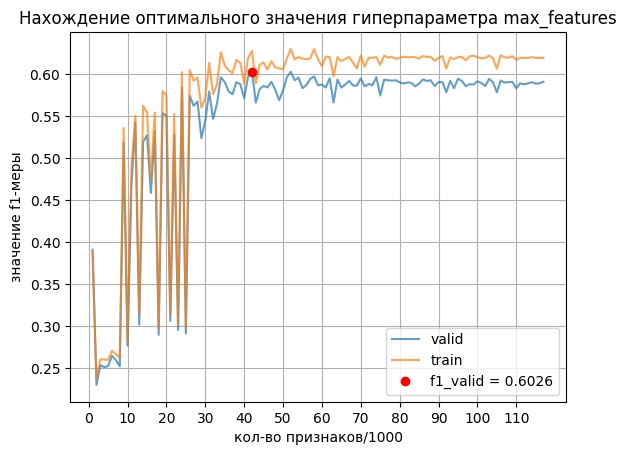

In [30]:
num_features = pd.DataFrame(data={'f1_valid':f1_valid_lst, 'f1_train':f1_train_lst}, index = range(1,118))
ax = num_features.plot(alpha=0.7)
pd.Series(f1_valid_max, index = [42]).plot(ax=ax, color='r', style='o', grid=True)
plt.legend(['valid', 'train', 'f1_valid = 0.6026'])
plt.xticks(range(0,120, 10))
plt.xlabel('кол-во признаков/1000')
plt.ylabel('значение f1-меры')
plt.title('Нахождение оптимального значения гиперпараметра max_features')
plt.show()

## **2.3 Случайный лес**

In [31]:
f1_valid_lst = []
f1_train_lst = []
f1_valid_max = 0
n_est_max = None
for est in notebook.tqdm(range(1, 30)):
  model_rfc = RandomForestClassifier(class_weight='balanced',
                                     max_depth=12,
                                     max_features=42000,
                                     n_estimators=est,
                                     random_state=12345)
  model_rfc.fit(features_train, target_train)

  preds_valid = model_rfc.predict(features_valid)
  f1_valid = f1_score(target_valid, preds_valid)

  preds_train = model_rfc.predict(features_train)
  f1_train = f1_score(target_train, preds_train)

  f1_valid_lst.append(f1_valid)
  f1_train_lst.append(f1_train)

  diff = abs(f1_valid - f1_train)*100/f1_train

  if f1_valid > f1_valid_max and diff < 5:
    f1_valid_max = f1_valid
    n_est_max = est
print(f'Максимальная f-мера = {f1_valid_max:.4f} при n_estimators = {n_est_max}')
f1_max_rf = f1_valid_max

  0%|          | 0/29 [00:00<?, ?it/s]

Максимальная f-мера = 0.6406 при n_estimators = 20


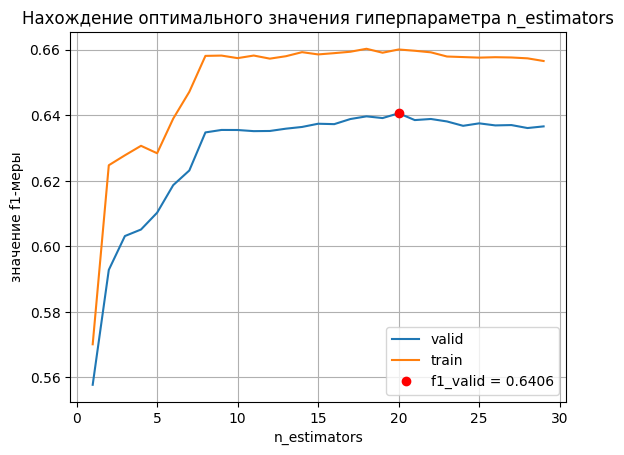

In [32]:
num_features = pd.DataFrame(data={'f1_valid':f1_valid_lst, 'f1_train':f1_train_lst}, index = range(1, 30))
ax = num_features.plot()
pd.Series(f1_valid_max, index = [n_est_max]).plot(ax=ax, color='r', style='o', grid=True)
plt.legend(['valid', 'train', 'f1_valid = 0.6406'])
#plt.xticks(range(0,30))
plt.xlabel('n_estimators')
plt.ylabel('значение f1-меры')
plt.title('Нахождение оптимального значения гиперпараметра n_estimators')
plt.show()

## **2.3 Catboost**

In [45]:
from google.colab import output
output.enable_custom_widget_manager()

train_pool = Pool(features_train, label=target_train)
test_pool = Pool(features_valid, label=target_valid)


cb_f1 = CatBoostClassifier(eval_metric='F1', iterations=700, learning_rate = 0.1, depth = 5, verbose=100)
cb_f1.fit(train_pool, eval_set=test_pool, plot=False)

0:	learn: 0.4196543	test: 0.4278487	best: 0.4278487 (0)	total: 1.72s	remaining: 20m 1s
100:	learn: 0.6487983	test: 0.6457143	best: 0.6458333 (96)	total: 2m 8s	remaining: 12m 41s
200:	learn: 0.7069475	test: 0.6950107	best: 0.6951622 (198)	total: 4m 10s	remaining: 10m 21s
300:	learn: 0.7352224	test: 0.7178124	best: 0.7178124 (300)	total: 6m 9s	remaining: 8m 9s
400:	learn: 0.7537893	test: 0.7282955	best: 0.7285687 (384)	total: 8m 9s	remaining: 6m 4s
500:	learn: 0.7645297	test: 0.7348077	best: 0.7354143 (492)	total: 10m 8s	remaining: 4m 1s
600:	learn: 0.7729674	test: 0.7405904	best: 0.7423516 (587)	total: 12m 6s	remaining: 1m 59s
699:	learn: 0.7810558	test: 0.7471601	best: 0.7473896 (692)	total: 14m 5s	remaining: 0us

bestTest = 0.7473896318
bestIteration = 692

Shrink model to first 693 iterations.


In [46]:
preds = cb_f1.predict(features_valid)
f1_cat = f1_score(target_valid, preds)
f1_cat

0.7473896318006961

# **3. Сделайте выводы**

Соберем все метрики f1 от разных моделей в одну таблицу.

In [47]:
results = pd.DataFrame(data={'F1-score':[f1_max_reg, f1_max_tree, f1_max_rf, f1_cat]},
                       index=['Лог. регрессия', 'Решающее дерево','Случайный лес',
                              'Catboost']).sort_values(by='F1-score', ascending=False)

In [48]:
results

,F1-score
Лог. регрессия,0.784750
Catboost,0.747390
Случайный лес,0.640568
Решающее дерево,0.602648


Лучшей по метрике `f1` показала себя модель логистической регрессии. Проверим ее на тестовых данных.

In [49]:
model_log_reg = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', C=8)
model_log_reg.fit(features_train, target_train)
proba = model_log_reg.predict_proba(features_test)
preds = (proba[:,1]>=t).astype(int)
f1 = f1_score(target_test, preds)
f1

0.7774584929757343

Модель прекрасно себя показала на тестовых данных и достигла требуемой метрики.